# Canary Deployment with Seldon and Istio

## Prerequistes
You will need
 - [Git clone of Seldon Core](https://github.com/SeldonIO/seldon-core)
 - A running Kubernetes cluster with kubectl authenticated
 - [seldon-core Python package](https://pypi.org/project/seldon-core/) (```pip install seldon-core>=0.2.6.1```)
 - [Helm client](https://helm.sh/)

### Creating a Kubernetes Cluster

Follow the [Kubernetes documentation to create a cluster](https://kubernetes.io/docs/setup/).

***This demo needs egress when running the load test to allow MNIST digits to be downloaded. If you want to run the load test then you will need to follow the docs on egress [here](https://istio.io/docs/tasks/traffic-management/egress/#calling-external-services-directly) if you run istio in a way that egress is blocked***

Once created ensure ```kubectl``` is authenticated against the running cluster.

## Setup

In [72]:
!kubectl create namespace seldon

namespace/seldon created


In [73]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [74]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


## Install Helm

In [75]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

serviceaccount/tiller created
clusterrolebinding.rbac.authorization.k8s.io/tiller created
$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [76]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


## Setup Istio

Ensure you have istio installed. Follow their [docs](https://istio.io/docs)

For this example we will create the default istio gateway for seldon which needs to be called `seldon-gateway`. You can supply your own gateway by adding to your SeldonDeployments resources the annotation `seldon.io/istio-gateway` with values the name of your istio gateway.

Create a gateway for our istio-ingress

In [77]:
!kubectl create -f ../../../notebooks/resources/seldon-gateway.yaml

gateway.networking.istio.io/seldon-gateway created


Label our namespace so istio creates sidecars

In [78]:
!kubectl label namespace seldon istio-injection=enabled

namespace/seldon labeled


If you are using Minikube for your Kubernetes cluster you will need to run as root in a separte terminal:
```
minikube tunnel
```
This will allow a LoadBalancer to be simulated on your local machine. 

In [1]:
INGRESS_HOST=!kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}'
INGRESS_PORT=!kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.spec.ports[?(@.name=="http2")].port}'
ISTIO_GATEWAY=INGRESS_HOST[0]+":"+INGRESS_PORT[0]

Check the istio gateway address

In [2]:
ISTIO_GATEWAY

'10.97.234.81:80'

To view the istio traffic you can go to the istio grafana dashboard. In a separate terminal port-forward to it:

See their docs [here](https://istio.io/docs/tasks/telemetry/metrics/using-istio-dashboard/)

## Start seldon-core

In [81]:
!helm install ../../../helm-charts/seldon-core-operator --name seldon-core --set istio.enabled=true --set usageMetrics.enabled=true --namespace seldon-system

NAME:   seldon-core
LAST DEPLOYED: Fri May 24 16:40:24 2019
NAMESPACE: seldon-system
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRole
NAME                          AGE
seldon-operator-manager-role  0s

==> v1/ClusterRoleBinding
NAME                                 AGE
seldon-operator-manager-rolebinding  0s

==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     0s

==> v1/Pod(related)
NAME                                         READY  STATUS             RESTARTS  AGE
seldon-operator-controller-manager-0         0/1    ContainerCreating  0         0s
seldon-spartakus-volunteer-5554c4d8b6-267h7  0/1    ContainerCreating  0         0s

==> v1/Secret
NAME                                   TYPE    DATA  AGE
seldon-operator-webhook-server-secret  Opaque  0     0s

==> v1/Service
NAME                                        TYPE       CLUSTER-IP      EXTERNAL-IP  PORT(S)  AGE
seldon-operator-controller-manager-service  ClusterIP  10.106.244.189  <none>       443/TC

In [82]:
!kubectl rollout status statefulset.apps/seldon-operator-controller-manager -n seldon-system

Waiting for 1 pods to be ready...
partitioned roll out complete: 1 new pods have been updated...


## Serve Single Model

In [4]:
from random import randint,random
import json
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from seldon_core.seldon_client import SeldonClient
import seldon_core

def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def predict_rest_mnist(mnist,deployment_name,namespace,istio_gateway):
    sc = SeldonClient(deployment_name=deployment_name,namespace=namespace,gateway_endpoint=istio_gateway)
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    features = ["X"+str(i+1) for i in range (0,784)]  
    r = sc.predict(gateway="istio",transport="rest",shape=(1,784),data=data,payload_type='ndarray',names=features)
    predictions = seldon_core.utils.seldon_message_to_json(r.response)
    print(predictions)
    #print("Route:"+json.dumps(predictions["meta"]["routing"],indent=2))
    fpreds = [ '%.2f' % elem for elem in predictions["data"]["ndarray"][0] ]
    m = dict(zip(predictions["data"]["names"],fpreds))
    print(json.dumps(m,indent=2))


In [5]:
%matplotlib inline
from visualizer import get_graph
mnist = download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
!kubectl apply -f mnist_v1.json

seldondeployment.machinelearning.seldon.io/mnist-classifier created


In [7]:
!kubectl rollout status deploy/mnist-deployment-sk-mnist-predictor-73d7608

Waiting for deployment "mnist-deployment-sk-mnist-predictor-73d7608" rollout to finish: 0 of 1 updated replicas are available...
deployment "mnist-deployment-sk-mnist-predictor-73d7608" successfully rolled out


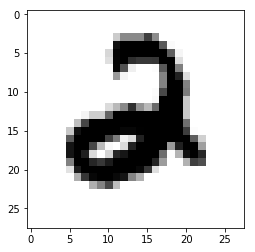

{'meta': {'puid': 'hm1lr3befsgnmis0g2pj6o0kka', 'requestPath': {'sk-mnist-classifier': 'seldonio/sk-example-mnist:0.2'}}, 'data': {'names': ['class:0', 'class:1', 'class:2', 'class:3', 'class:4', 'class:5', 'class:6', 'class:7', 'class:8', 'class:9'], 'ndarray': [[0.0, 0.0, 0.9333333333333333, 0.03333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03333333333333333]]}}
{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "0.93",
  "class:3": "0.03",
  "class:4": "0.00",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.03"
}


In [8]:
predict_rest_mnist(mnist,"mnist-classifier","seldon",ISTIO_GATEWAY)

## Start a Load Test

In [9]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node/minikube labeled


In [16]:
!helm install ../../../helm-charts/seldon-core-loadtesting --name loadtest  \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://{ISTIO_GATEWAY} \
    --set rest.pathPrefix=/seldon/seldon/mnist-classifier \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Sat May 25 12:05:44 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Pod(related)
NAME                   READY  STATUS       RESTARTS  AGE
locust-master-1-t9bkh  2/2    Terminating  0         92s
locust-master-1-wxvcn  0/2    Init:0/1     0         1s
locust-slave-1-4zf48   2/2    Terminating  0         92s
locust-slave-1-9dxfk   0/2    Pending      0         1s

==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-master-1  1        1        0      1s
locust-slave-1   1        1        0      1s

==> v1/Service
NAME             TYPE      CLUSTER-IP     EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.102.201.97  <none>       5557:31657/TCP,5558:31761/TCP,8089:30560/TCP  0s




Now we will add a canary and split traffic 75% to 25% to it. This is done by adding a new predictor to the SeldonDeployment and specifying the traffic values.

In [17]:
!pygmentize mnist_v2.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/sk-example-mnist:0.2",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "sk-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                    

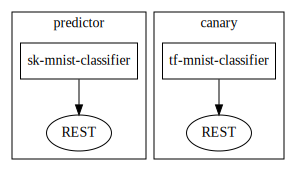

In [18]:
get_graph("mnist_v2.json")

In [19]:
!kubectl apply -f mnist_v2.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured


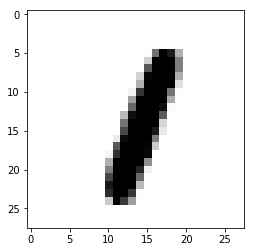

{'meta': {'puid': 'kmgokkdro5cm3lo0b1d5nbe1vs', 'requestPath': {'sk-mnist-classifier': 'seldonio/sk-example-mnist:0.2'}}, 'data': {'names': ['class:0', 'class:1', 'class:2', 'class:3', 'class:4', 'class:5', 'class:6', 'class:7', 'class:8', 'class:9'], 'ndarray': [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}}
{
  "class:0": "0.00",
  "class:1": "1.00",
  "class:2": "0.00",
  "class:3": "0.00",
  "class:4": "0.00",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.00"
}


In [20]:
predict_rest_mnist(mnist,"mnist-classifier","seldon",ISTIO_GATEWAY)

You should see traffic being split on the Istio service dashboard for the mnist-classifier.

![canary](canary.png)

When you are happy the canary is ok you can promote to full traffic.

In [148]:
!kubectl apply -f mnist_v3.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured


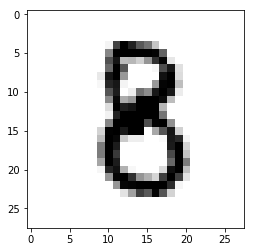

<Response [200]>
Route:{}
{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "0.01",
  "class:3": "0.11",
  "class:4": "0.00",
  "class:5": "0.04",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.84",
  "class:9": "0.00"
}


In [102]:
predict_rest_mnist(mnist,"mnist-classifier","seldon",ISTIO_GATEWAY)

You should now see all traffic transfer to the canary.

![promoted](promoted-canary.png)